# Anatomy of Neural Networks using PyTorch

In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Say we have the function $f(x)$ = $(x−2)^2$. Let’s define that with some PyTorch code and plot what the function looks like:

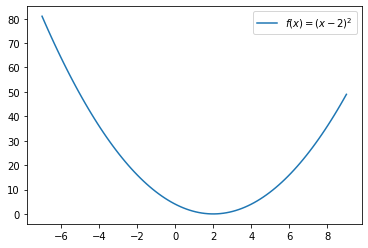

In [5]:
def f(x):
    return torch.pow((x-2.0), 2)

x_axis_vals = np.linspace(-7,9,100) 
y_axis_vals = f(torch.tensor(x_axis_vals)).numpy()

sns.lineplot(x=x_axis_vals, y=y_axis_vals, label='$f(x)=(x-2)^2$');

## Using derivatives to minimize losses

We can clearly see that the minimum of this function is at x = 2, where we get the value f(2) = 0. But this is an intentionally easy problem. Let’s say we can’t plot it; we can use calculus to help us find the answer.

How is that possible? Let’s plot f(x) and f′(x) at the same time:

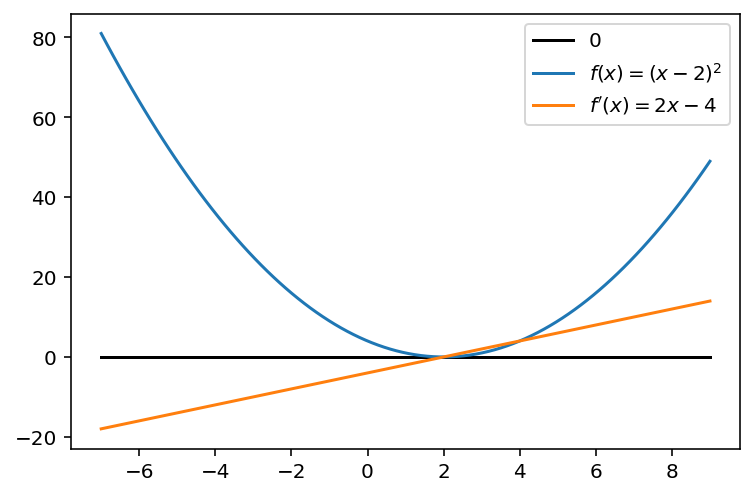

In [13]:
def fP(x): #Defining the derivative of f(x) manually
    return 2*x-4

y_axis_vals_p = fP(torch.tensor(x_axis_vals)).numpy()

#First, lets draw a black line at 0, so that we can easily tell if something is positive or negative
sns.lineplot(x=x_axis_vals, y=[0.0]*len(x_axis_vals), label="0", color='black')
sns.lineplot(x=x_axis_vals, y=y_axis_vals, label='$f(x) = (x-2)^2$')
sns.lineplot(x=x_axis_vals, y=y_axis_vals_p, label="$f'(x)=2 x - 4$");

## Calculating a derivative with automatic differentiation

Now that we understand the concept of minimizing a function using its derivative, let’s walk through the mechanics of doing it in PyTorch. First, let’s create a new variable to minimize. We do this similar to before, but we add a new flag telling PyTorch to keep track of the gradient. This is stored in a variable called grad, which does not exist yet since we haven’t computed anything:

In [14]:
x = torch.tensor([-3.5], requires_grad=True)
print(x.grad)

None


We see there is no current gradient. Let’s try computing f(x), though, and see if anything changes now that we set requires_grad=True:

In [17]:
value = f(x) 
value.backward()
print(x.grad)

tensor([-11.])


Once we tell PyTorch to start calculating gradients, it begins to keep track of every computation we do. It uses this information to go backward and calculate the gradients for everything that was used and had a requires_grad flag set to True. Once we have a single scalar value, we can tell PyTorch to go back and use this information to compute the gradients. This is done using the .backward() function, after which we see a gradient in our original object.

With that, we have now computed a gradient for the variable x. Part of the power of PyTorch and automatic differentiation is that you can make the function f(x) do almost anything, as long as it is implemented using PyTorch functions. The code we wrote for computing the gradient of x will not change. PyTorch handles all the details of how to compute it for us.

## Minimizing a function with derivatives

Now that PyTorch can compute gradients for us, we can use the automatic differentiation of our PyTorch function f(x) to numerically find the answer f(2) = 0. We are going to describe it first using mathematical notation and then in code.

This equation shows the math for what is known as gradient descent:

![](https://drive.google.com/uc?id=1fB_wIJQjGvVO76Ii4BsdUmkuj1suam8l&authuser=recohut.data.001%40gmail.com&usp=drive_fs)

At the end of the loop, we print the value of xcur and see that it is equal to 2.0; PyTorch found the answer. Notice that when we define a PyTorch Tensor object, it has a child member .grad that stores the computed gradients for that variable, as well as a .data member that holds the underlying value. You usually shouldn’t access either of these fields unless you have a specific reason to; for now, we are using them to demonstrate the mechanics of autograd:

In [18]:
x = torch.tensor([-3.5], requires_grad=True)

x_cur = x.clone()
x_prev = x_cur*100 #Make the initial "previous" solution larger
epsilon = 1e-5
eta = 0.1

while torch.linalg.norm(x_cur-x_prev) > epsilon:
    x_prev = x_cur.clone() #We need to make a clone here so that x_prev and x_cur don't point to the same object
    
    #Compute our function, gradient, and update
    value = f(x)
    value.backward()
    x.data -= eta * x.grad
    x.grad.zero_() #We need to zero out the old gradient, as py-torch will not do that for us
    
    #What are we currently now?
    x_cur = x.data
    
print(x_cur)

tensor([2.0000])


Note: `backpropagation` is the name of the original algorithm used to compute all the gradients in a neural network. Personally, I think backpropagation is a very intimidating place to start, as it involves a lot more math and drawing graphs, but it is fully encapsulated by automatic differentiation. With modern frameworks like PyTorch, you don’t need to know about the mechanics of backpropagation to get started.

## Optimizing parameters

What we just did, finding the minimum of a function f(⋅), is called optimization. Because we specify the goal of our network using a loss function ℓ(⋅), we can optimize f(⋅) to minimize our loss. If we reach a loss ℓ(⋅) = 0, our network appears to have solved the problem. This is why we care about optimization and is foundational to how most modern neural networks are trained today.

Because of how important optimization is, PyTorch includes two additional concepts to help us: parameters and optimizers. A Parameter of a model is a value that we alter using an Optimizer to try to reduce our loss ℓ(⋅). We can easily convert any tensor into a Parameter using the nn.Parameter class.

![](https://drive.google.com/uc?id=1f6VJeWXtsbe9ccjK-I-azhF2mp9P2rP9&authuser=recohut.data.001%40gmail.com&usp=drive_fs)

In [19]:
x_param = torch.nn.Parameter(torch.tensor([-3.5]), requires_grad=True)
optimizer = torch.optim.SGD([x_param], lr=eta)

for epoch in range(60):
    optimizer.zero_grad() #x.grad.zero_()
    loss_incurred  = f(x_param)
    loss_incurred.backward()
    optimizer.step() #x.data -= eta * x.grad
    
print(x_param.data)

tensor([2.0000])


The code prints out tensor(2.0000), just like before. This will make our lives easier when we have literally millions of parameters in our network.

Now that we understand how PyTorch gives us tensors to represent our data and parameters, we can progress to building our first neural networks. This starts with showing how learning happens in PyTorch. As we described above, learning is based on the principle of optimization: we can compute a loss for how well we are doing and use gradients to minimize that loss. This is how the parameters of a network are “learned” from the data and is also the basis of many different machine learning (ML) algorithms. For these reasons, optimization of loss functions is the foundation PyTorch is built from. So to implement any kind of neural network in PyTorch, we must phrase the problem as an optimization problem (remember that this is also called function minimization).

## Neural networks process

The three major steps to training a model in PyTorch.

1. The input data drives learning. 
2. The model is used to make a prediction, and a loss scores how much the prediction and true label differ. 
3. PyTorch’s automatic differentiation is used to update the parameters of the model, improving its predictions.

![](https://drive.google.com/uc?id=1f4hdBcquHBkMEAet8TWLbAbiO2Vx8UFo&authuser=recohut.data.001%40gmail.com&usp=drive_fs)